# **Analysis of Docking Results**

## 1. Extraction of Binding Affinities

After docking, AutoDock Vina produces `.log` files containing predicted binding affinities (in kcal/mol). These files were collected into a `/logs` directory for structured analysis.

All results in this notebook are generated from the provided `.log` files. Running the code with the same input files reproduces these outputs.

In [9]:
# Upload requirements.txt and install environment
!pip install -r requirements.txt

In [10]:
import os
import pandas as pd

In [12]:
# Create logs folder
log_folder = "/content/logs"
os.makedirs("/content/logs", exist_ok=True)
print("Folder created: /content/logs")

# Move all .log files into logs folder
!mv /content/*.log /content/logs/ 2>/dev/null

Folder created: /content/logs


Each `.log` corresponds to a specific ligand–receptor pair, and the top-ranked binding mode was extracted. Receptor file names were mapped to their biological labels (for example, `EGFR_wt_4WKQ_nowater` → `Wildtype 4WKQ`) to simplify interpretation.

In [13]:
# Map receptor filenames to biological labels
receptor_map = {
    "EGFR_wt_4WKQ_nowater": "Wildtype 4WKQ",
    "EGFR_wt_4G5J_nowater": "Wildtype 4G5J",
    "EGFR_wt_8F1X_nowater": "Wildtype 8F1X",
    "EGFR_T790M_6JX0_nowater": "T790M 6JX0",
    "EGFR_T790M_4G5P_nowater": "T790M 4G5P",
    "EGFR_T790M_5GMP_nowater": "T790M 5GMP",
    "EGFR_L858R_2ITZ_nowater": "L858R 2ITZ",
    "EGFR_L858R_6JWL_nowater": "L858R 6JWL",
    "EGFR_L858R_2ITT_nowater": "L858R 2ITT",
    "EGFR_exon20_4LRM_nowater": "Exon20 4LRM",
    "EGFR_exon20_9GC6_nowater": "Exon20 9GC6",
    "EGFR_exon20_9GL8_nowater": "Exon20 9GL8"
}

In [14]:
# Extract first-ranked binding mode affinity from each log file
results = []

for filename in os.listdir(log_folder):
    if filename.endswith(".log"):
        filepath = os.path.join(log_folder, filename)
        ligand, receptor = filename.replace(".log", "").split("_", 1)
        affinity = None
        with open(filepath, "r") as f:
            for line in f:
                if line.strip().startswith("1 "):
                    affinity = float(line.split()[1])
                    break
        if affinity is not None:
            results.append([receptor, ligand, affinity])

## 2. Binding Affinity Table

The extracted affinities were compiled into a table with receptors as rows and ligands as columns. This provides a clear overview of predicted binding strengths for each ligand across all receptors.

Raw docking logs are included for transparency. Differences between receptor PDB files can influence binding affinities; further discussion of these effects is provided in [`discussion.md`](/notes/discussion.md).

In [15]:
df = pd.DataFrame(results, columns=["EGFR Receptor", "Ligand", "Affinity (kcal/mol)"])

# Pivot table: receptors as rows, ligands as columns
pivot = df.pivot(index="EGFR Receptor", columns="Ligand", values="Affinity (kcal/mol)")

# Remove the automatic "Ligand" name above columns
pivot.columns.name = None

# Map receptor filenames to biological names
pivot.index = pivot.index.to_series().replace(receptor_map)

# Sort receptors
receptor_order = [
    "Wildtype 4WKQ", "Wildtype 4G5J", "Wildtype 8F1X",
    "L858R 2ITZ", "L858R 6JWL", "L858R 2ITT",
    "T790M 6JX0", "T790M 4G5P", "T790M 5GMP",
    "Exon20 4LRM", "Exon20 9GC6", "Exon20 9GL8"
]
pivot = pivot.loc[receptor_order]

# Reset index so "Receptor" becomes a column
pivot = pivot.reset_index().rename(columns={"EGFR Receptor": "EGFR Receptor"})

pivot

,EGFR Receptor,Afatinib,Aspirin,Caffeine,Erlotinib,Gefitinib,Ibuprofen,Mobocertinib,Osimertinib
0,Wildtype 4WKQ,-7.832,-5.669,-5.228,-7.646,-8.306,-6.214,-7.766,-7.637
1,Wildtype 4G5J,-7.454,-5.448,-5.141,-6.618,NaN,-6.387,-7.304,-7.242
2,Wildtype 8F1X,-7.986,-5.463,-5.180,-7.326,-7.715,-6.231,-8.729,-7.976
3,L858R 2ITZ,-7.996,-5.520,-5.191,-6.766,-7.703,-6.254,-7.603,-7.543
4,L858R 6JWL,-7.305,-5.132,-4.989,-6.117,-7.209,-5.850,-7.626,-7.314
5,L858R 2ITT,-7.430,-5.186,-4.981,-6.712,-7.726,-6.322,-8.137,-7.803
6,T790M 6JX0,-7.835,-5.175,-5.174,-6.639,-7.857,-6.227,-7.729,-7.947
7,T790M 4G5P,-8.364,-5.340,-5.314,-7.123,-8.003,-5.984,-7.936,-8.412
8,T790M 5GMP,-6.990,-4.672,-5.005,-5.912,-6.771,-5.740,-7.371,-7.152
9,Exon20 4LRM,-9.171,-5.436,-5.802,-7.431,-8.605,-6.447,-8.054,-9.079


## 3. Statistical Summary

For each EGFR mutation class (Wildtype, L858R, T790M, Exon20), the mean and standard deviation of binding affinities were calculated.

Results are reported as mean ± SD, giving a quantitative summary of ligand performance across each mutation type.

In [16]:
df_summary = pivot.copy()

# Extract mutations
df_summary["Mutation class"] = df_summary["EGFR Receptor"].str.split().str[0]

# Identify ligand columns
ligand_cols = [c for c in df_summary.columns if c not in ["EGFR Receptor", "Mutation class"]]

# Group by mutation and calculate mean and std
means = df_summary.groupby("Mutation class")[ligand_cols].mean()
stds = df_summary.groupby("Mutation class")[ligand_cols].std()

# Combine into "mean ± std" strings
summary = (means.round(2).astype(str) + " ± " + stds.round(2).astype(str)).reset_index()

# Reset index and rename
summary = summary.rename(columns={"Mutation class": "EGFR Receptor"})

# Order mutations logically
order = ["Wildtype", "L858R", "T790M", "Exon20"]
summary["EGFR Receptor"] = pd.Categorical(summary["EGFR Receptor"], categories=order, ordered=True)
summary = summary.sort_values("EGFR Receptor").reset_index(drop=True)

summary

,EGFR Receptor,Afatinib,Aspirin,Caffeine,Erlotinib,Gefitinib,Ibuprofen,Mobocertinib,Osimertinib
0,Wildtype,-7.76 ± 0.27,-5.53 ± 0.12,-5.18 ± 0.04,-7.2 ± 0.53,-8.01 ± 0.42,-6.28 ± 0.1,-7.93 ± 0.73,-7.62 ± 0.37
1,L858R,-7.58 ± 0.37,-5.28 ± 0.21,-5.05 ± 0.12,-6.53 ± 0.36,-7.55 ± 0.29,-6.14 ± 0.26,-7.79 ± 0.3,-7.55 ± 0.24
2,T790M,-7.73 ± 0.69,-5.06 ± 0.35,-5.16 ± 0.15,-6.56 ± 0.61,-7.54 ± 0.67,-5.98 ± 0.24,-7.68 ± 0.29,-7.84 ± 0.64
3,Exon20,-9.12 ± 0.33,-5.93 ± 0.61,-5.75 ± 0.18,-7.91 ± 0.42,-8.93 ± 0.33,-6.74 ± 0.44,-8.4 ± 0.75,-8.69 ± 0.63


## 4. Best Binding Ligand per Receptor

For every receptor, the ligand with the lowest (most negative) binding affinity was identified. These top binders are highlighted in the table for clarity, providing a quick reference to the most promising compounds per receptor:

In [17]:
# Create dataframe (without std, since pandas can not recognise strings)
affinity_df = pd.DataFrame({
    "EGFR Receptor": ["Wildtype", "L858R", "T790M", "Exon20"],
    "Afatinib": [-7.76, -7.58, -7.73, -9.12],
    "Aspirin": [-5.53, -5.28, -5.06, -5.93],
    "Caffeine": [-5.18, -5.05, -5.16, -5.75],
    "Erlotinib": [-7.20, -6.53, -6.56, -7.91],
    "Gefitinib": [-7.85, -7.55, -7.54, -8.93],
    "Ibuprofen": [-6.28, -6.14, -5.98, -6.74],
    "Mobocertinib": [-7.93, -7.79, -7.68, -8.40],
    "Osimertinib": [-7.62, -7.55, -7.84, -8.69]
})

In [18]:
# Function to highlight best affinity (most negative) in each row
def highlight_best(row):
    best = row.min()
    return ['background-color: green' if v == best else '' for v in row]

# Apply highlighting (skip first column with receptor names)
styled_df = affinity_df.style.apply(
    highlight_best,
    subset=affinity_df.columns[1:],
    axis=1
)

styled_df

,EGFR Receptor,Afatinib,Aspirin,Caffeine,Erlotinib,Gefitinib,Ibuprofen,Mobocertinib,Osimertinib
0,Wildtype,-7.760000,-5.530000,-5.180000,-7.200000,-7.850000,-6.280000,-7.930000,-7.620000
1,L858R,-7.580000,-5.280000,-5.050000,-6.530000,-7.550000,-6.140000,-7.790000,-7.550000
2,T790M,-7.730000,-5.060000,-5.160000,-6.560000,-7.540000,-5.980000,-7.680000,-7.840000
3,Exon20,-9.120000,-5.930000,-5.750000,-7.910000,-8.930000,-6.740000,-8.400000,-8.690000


## 5. Heatmap Visualisation

A heatmap was generated to visualise binding affinities across all ligand–receptor pairs. The most effective ligand for each receptor is additionally circled, making it easy to identify trends and compare relative binding strengths at a glance.

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

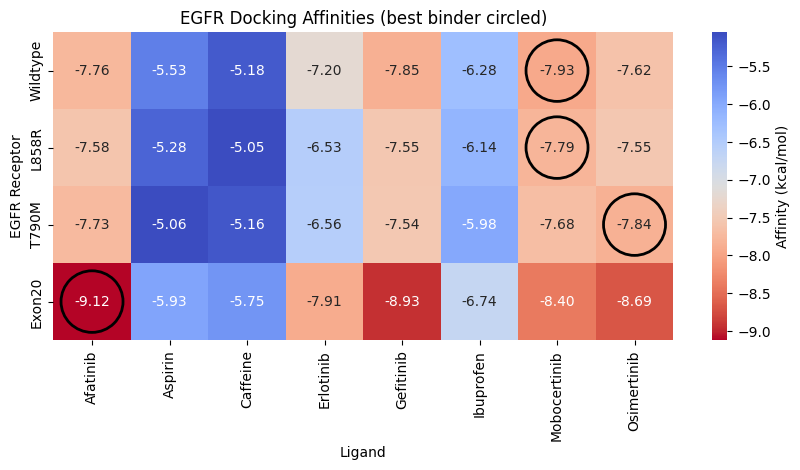

In [20]:
# Set EGFR receptor as index for heatmap
df_heatmap = affinity_df.set_index("EGFR Receptor")

# Plot heatmap
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    df_heatmap,
    annot=True,
    fmt=".2f",
    cmap="coolwarm_r",
    cbar_kws={'label': 'Affinity (kcal/mol)'},
)

# Highlight best binder per receptor
best_per_receptor = df_heatmap.idxmin(axis=1)
for i, receptor in enumerate(df_heatmap.index):
    best_ligand = best_per_receptor[receptor]
    j = df_heatmap.columns.get_loc(best_ligand)
    circ = Circle((j + 0.5, i + 0.5), 0.4, color='black', fill=False, lw=2)
    ax.add_patch(circ)

plt.title("EGFR Docking Affinities (best binder circled)")
plt.ylabel("EGFR Receptor")
plt.xlabel("Ligand")
plt.show()